https://chat.openai.com/share/05195db4-a3e5-4b1c-af16-6fe558ac7a35

In [1]:
import pandas 
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)
  
#read from google drive
data=pandas.read_csv("https://drive.google.com/uc?export=download&id=1LU5be_H1TD2Pp1OmI202to3YyKo9AzFY")
  
print(data.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


In [2]:
# inspect the data to look for wrong data
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [3]:
data.groupby('country').size()

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64

In [4]:
data.groupby(['source']).size()

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64

A few quick observations:
1. the user base is pretty young; most of users are relatively young, lower than 40 years old
2. the conversion rate is about 3%, which is similar to industry standard, makes sense
3. it is probably a US site, although Chinese user base are large as well
4. the maximum age is 123 yrs, need further investigation
5. Seo is the main way to visit the site

In [5]:
# investigate age column
sorted(data['age'].unique(), reverse=True)

[123,
 111,
 79,
 77,
 73,
 72,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17]

Those 123 and 111 values seem unrealistic, How many users are we talking about:

In [6]:
data[data['age']>100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


Since we don‘t see any pattern of these unrealistic numbers ans they are only 2 records, so we can safely remove them here.
(if there is, talk to software engineer to see if there are some bugs in the logging code which will affect the data significantly.)

In [7]:
data = data[data['age'] <110]

Investigate variables and see how their distribution differs for the two class. This can help us understand the information in our data in the first place and get a sense of the data.

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout' : True})

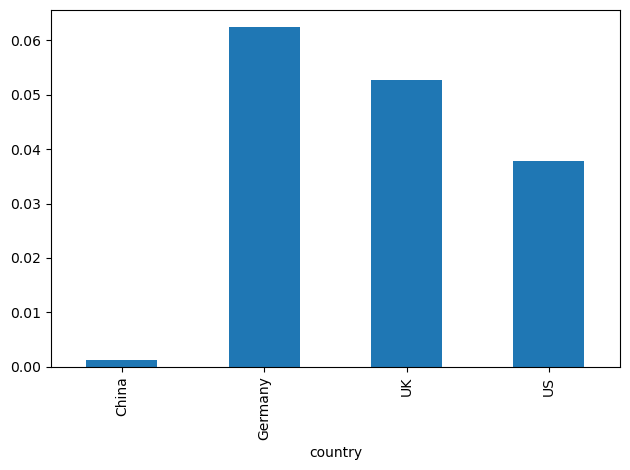

In [9]:
data.groupby(['country'])['converted'].mean().plot.bar()
plt.show()

China has a much lower conversion rate than other countries.

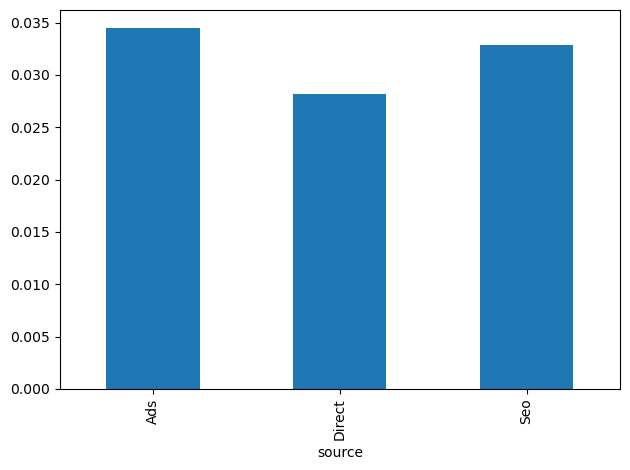

In [10]:
data.groupby(['source'])['converted'].mean().plot.bar()
plt.show()

all three ways have a similar conversion rate

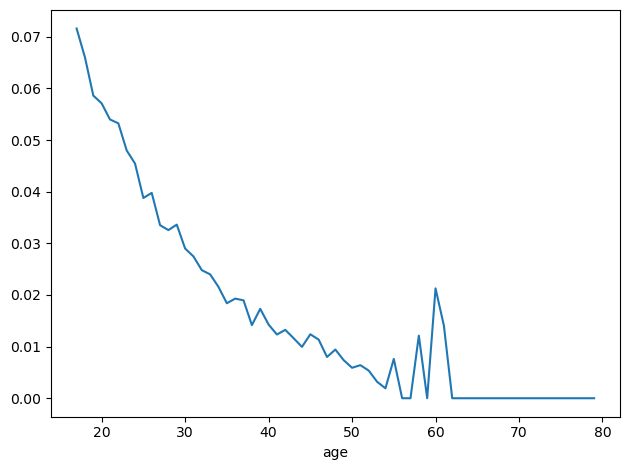

In [11]:
data.groupby(['age'])['converted'].mean().plot()
plt.show()

users above around 30 years old have a lower conversion rate.

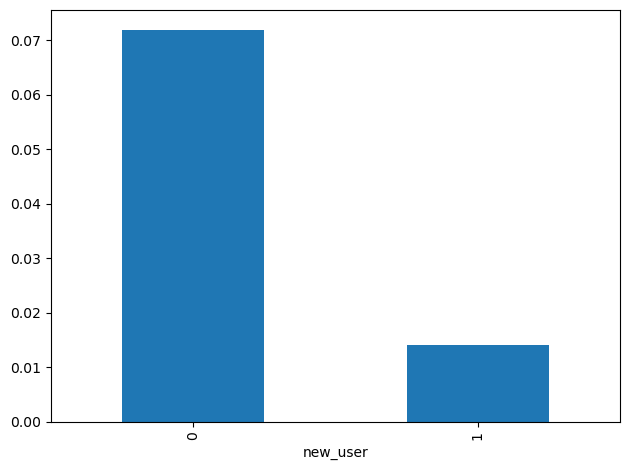

In [12]:
data.groupby(['new_user'])['converted'].mean().plot.bar()
plt.show()

old users seem to have a higher conversion rate.

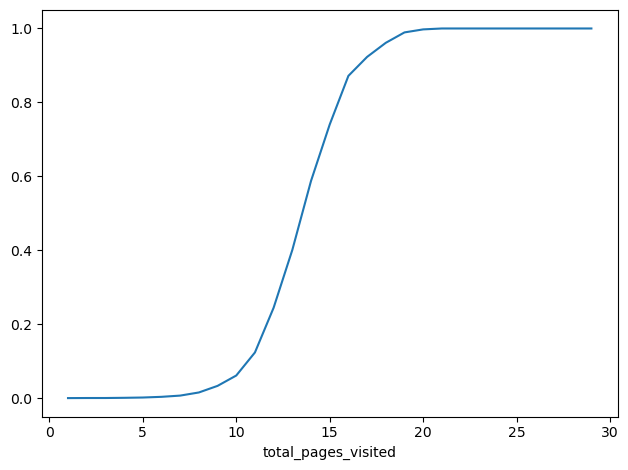

In [13]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show()

Spending more time on the site implies higher probability of conversion.

## Build Machine Learning model

Since the outcome is binary and we care about give product and marketing team project ideas, so we should choose among the following options:
1. Logistic regression
2. Decision tree
3. RuleFit?
4. Random forest or Boosted decision trees in combination with partial dependence plots.

Here, we are going to pick random forest because:
it requires very little time to optimize it and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use random forest to predict conversion, then use partial dependence plots and feature importance to get insights. Also, I will build a simple decision tree to find the most obvious user segments.?

In [14]:
# encode the categorical variables
data_encoded = pandas.get_dummies(data, drop_first=True)

In [15]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
np.random.seed(4684)

# create test and training set
X = data_encoded.drop('converted', axis=1)
y = data_encoded['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34)

create test/training set with a standard 66% split(if the data is too small, I will cross-validate), then, build the forest with 100 trees, trees as large as possible, 3 random variables selected at each split.

In [16]:
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(X_train, y_train)
cm = confusion_matrix(y_train, rf.oob_decision_function_[:,1].round())
#print the oob score and confusion matrix
print(rf.oob_score_)
print(pandas.DataFrame(cm, columns = [0,1])
)

0.9838851885571901
        0     1
0  200872  1102
1    2261  4455


In [17]:
rf.oob_decision_function_

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [18]:
# print test accuracy and confusion matrix
cm_test = confusion_matrix(y_test, rf.predict(X_test))
print(rf.score(X_test, y_test))
print(pandas.DataFrame(cm_test, columns=[0,1]))

0.9847360196450496
        0     1
0  103483   543
1    1098  2384


1. the oob accuracy is pretty similar to the test acurracy, ~1.1%, so we are confident we are not overfitting
2. Since the accuracy started from 97% (that's the case if we classified everything as 'non-converted'), so 98.5% is good, but nothing shocking. 
3. about 30% of conversions are predicted as non-conversion. If we care about minimizing false positives/ false negatives, we would find the best cut-off point. Since in this case, that doesn't appear to be particularly relevant, so we are fine with 0.5 cut-off value used internally by the rf to make the prediction.

### we need to check that the model predicts well, so let's start by checking the variable importance.

In [19]:
rf.feature_importances_

array([0.11858269, 0.0391469 , 0.7896411 , 0.01038969, 0.01189488,
       0.01385541, 0.00736031, 0.00912903])

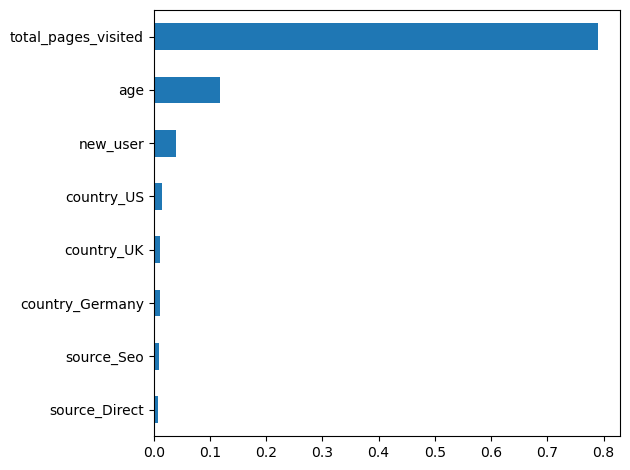

In [20]:
feat_importance = pandas.Series(rf.feature_importances_, index=X_train.columns)
feat_importance.sort_values().plot(kind = 'barh')
plt.show()

Total pages visited is the most important one. But it is the least actionable. We can not give insights to manager like, reaching out to those who have many pageviews. People visit many pages because they already want to buy, and also, they have to click on multiple pages in order to buy. So we need to rebuild the rf without that variable. Since we don't have that very powerful variable, we should change weights to make sure we will get something classified as 1.
https://chat.openai.com/share/615f1df3-7763-4d31-8673-4f699f9a1d36

In [21]:
# rebuild the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(X_train.drop('total_pages_visited', axis = 1), y_train)
cm = confusion_matrix(y_train, rf.oob_decision_function_[:,1].round())
print(rf.oob_score_)
print(pandas.DataFrame(cm, columns=[0,1]))

0.889827016148354
        0      1
0  182720  19254
1    3738   2978


In [22]:
cm_test = confusion_matrix(y_test, rf.predict(X_test.drop('total_pages_visited', axis = 1)))
print(rf.score(X_test.drop('total_pages_visited', axis = 1), y_test))
print(pandas.DataFrame(cm_test, columns=[0,1]))

0.8899802805372623
       0     1
0  94140  9886
1   1942  1540


<Axes: >

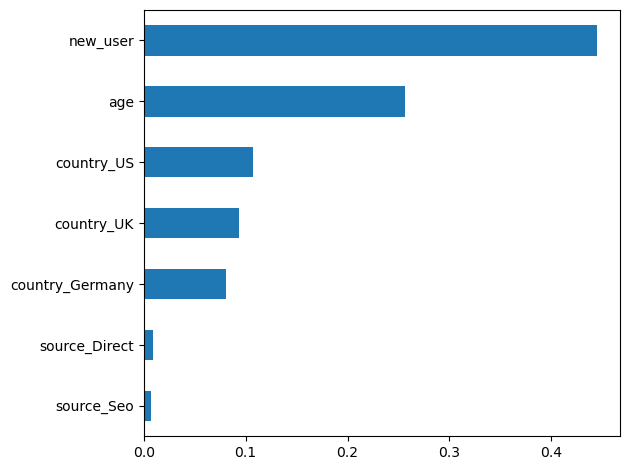

In [23]:
feat_importance = pandas.Series(rf.feature_importances_, index=X_train.drop('total_pages_visited', axis = 1).columns)
feat_importance.sort_values().plot(kind = 'barh')

We find that new_user is the most important one. That's impressive given that we know how continuous variables tend to always show up at the top in RF variable importance plots. It means new_user is really important. Source-related dummies don't seem to matter at all.

Let's check the partial dependence plots for 4 vars.

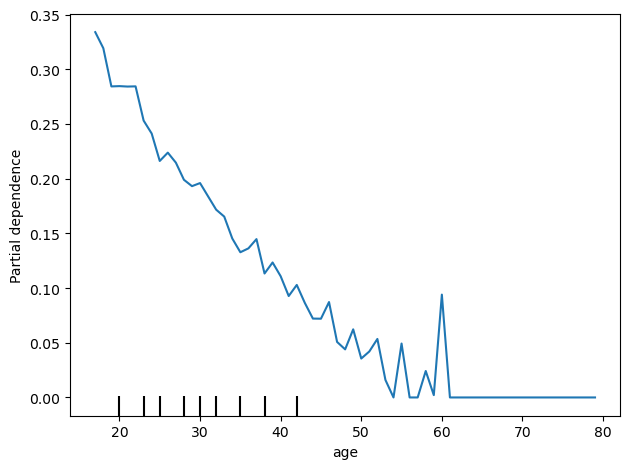

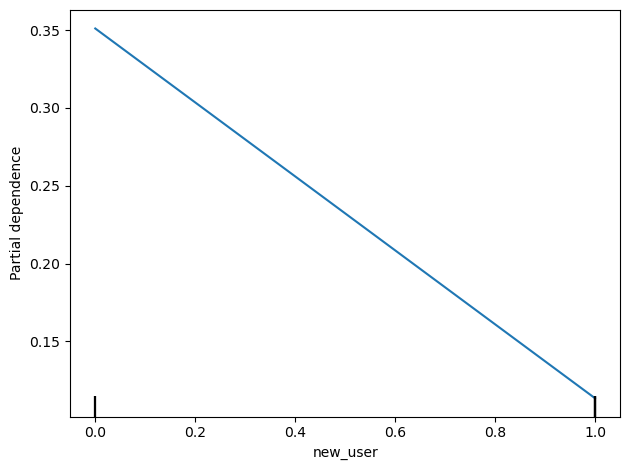

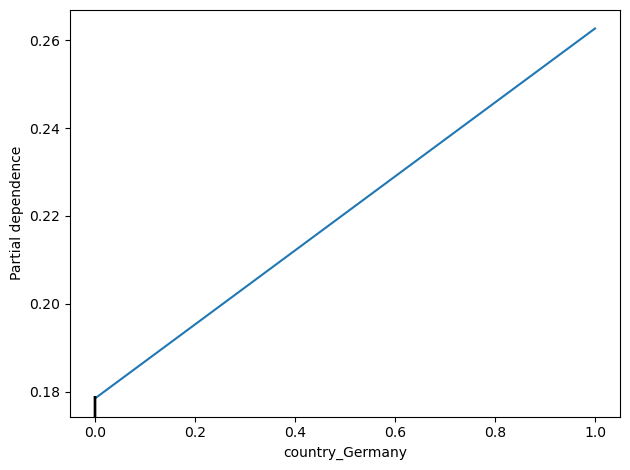

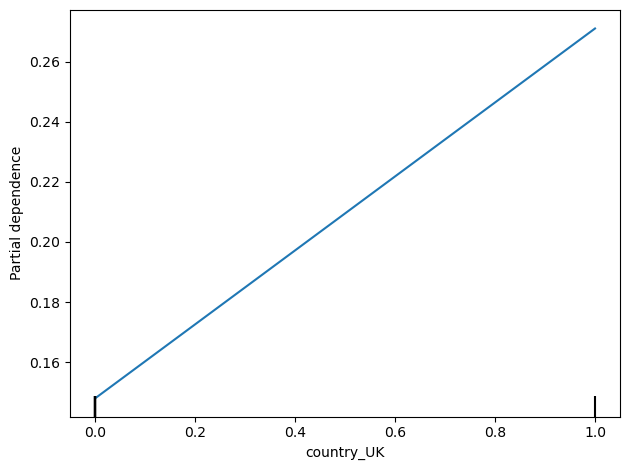

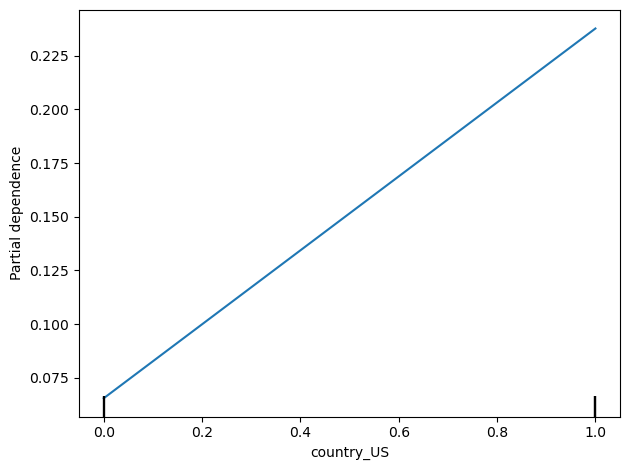

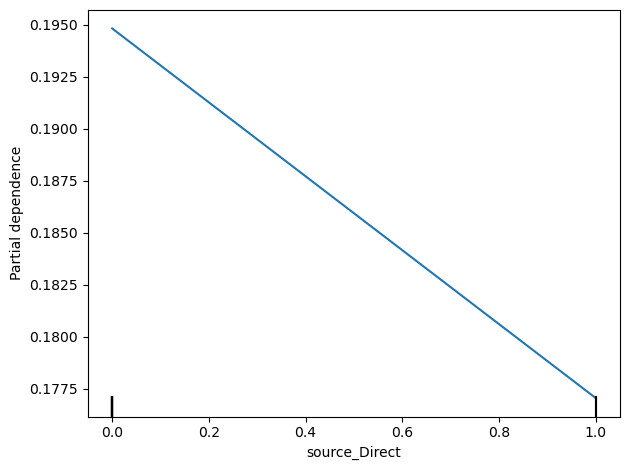

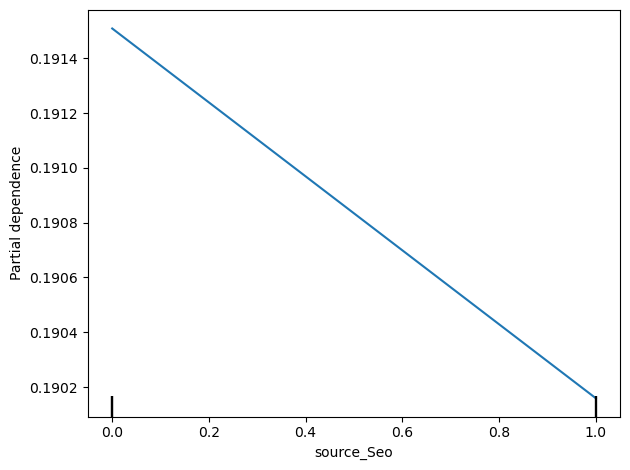

In [24]:
from sklearn.inspection import PartialDependenceDisplay

i = 0
while i<len(feat_importance) :
    display = PartialDependenceDisplay.from_estimator(rf, X_train.drop('total_pages_visited', axis = 1), [i,])
    plt.show()
    plt.close()
    i = i+1

This shows that:
1. site works well for young people and gets worse as age increases
2. users with old account convert much better than new users
3. Compared to the reference level China, Germany, UK and US users all have a good conversion rate. That is, China is very bad for conversion.
4. Source is less relevant.

Let's build a simple decision tree and check the 2 or 3 most important segments.

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source

In [30]:
dt = DecisionTreeClassifier(max_depth=2, class_weight={0:1, 1:10}, min_impurity_decrease=0.001)
dt.fit(X_train.drop('total_pages_visited',axis = 1), y_train)

#visualize it
export_graphviz(dt, out_file='tree_conversion.dot', feature_names=X_train.drop('total_pages_visited', axis = 1).columns, proportion=True, rotate=True)
s = Source.from_file('tree_conversion.dot')
s.view()

'tree_conversion.dot.pdf'

Conclusions and next steps:
1. this site works well for young people, I'll tell marketing to advertise and use channels which are more likely to reach young people.
2. Users with old accounts do much better. We can try to use targeted emails with offers to bring them back.
3. German users converted well but there are few Germans coming to the site. Marketing should get more Germans.
4. Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o, conversion starts dropping. We use conversion rate for people >= 30 yr old as a metric, and build a team whose goal is to increase that number.
5. Something wrong with the Chinese site. There are a huge amount of Chinese users but with a lowest conversion rate. It is either poorly translated, doesn't fit the local culture, or maybe some payment issue. Fixing this is the top priority given how many users are based in China.